In [1]:
import os
import glob
os.system("curl https://mschneid.web.cern.ch/mschneid/randomprojections_ZeroBias_2018C.csv.gz | zcat > in.csv")
files = ["in.csv"]
#files = glob.glob("/data/mschneid/randomprojection/CMSSW_11_1_0_pre7/src/randomprojections/*.out")

In [2]:
from collections import defaultdict
projections_ = defaultdict(list)
for file in files:
    print(file)
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            row = line.split(",")
            projections_[row[0]].append(row)

projections = dict()
for k in projections_:
    rows = projections_[k]
    name = k.split("_")[1]
    projections[name] = rows
del projections_

in.csv


In [5]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# run again if this does not work the first time
matplotlib.rcParams['figure.figsize'] = [15, 8]

In [6]:
# a quick sanity check of the data
runlumis = set()
for k in projections:
    rows = projections[k]
    runlumis.add(tuple((row[1], row[2]) for row in rows))
assert len(runlumis) == 1
#[(run, lumi) for run, lumi in sorted(list(runlumis)[0]) if run == "320040"]

In [7]:
# this converts the data to a more useful form
def project(ndimeach, subsystems = sorted(projections.keys())):
    result = defaultdict(list)
    labels = []
    for k in subsystems:
        rows = projections[k]
        name = k
        labels += [name]*ndimeach
        for row in rows:
            result[(int(row[1]), int(row[2]))] += row[3:3+ndimeach]
    runlumis = sorted(result.keys())
    matrix = [result[rl] for rl in runlumis]
    return labels, runlumis, matrix

In [8]:
# for up to 1024 dimensions, this works all fine.
def simpleATA(A):
    return A.transpose().dot(A)

In [10]:
# now, let's select some data.
ndimeach = 128
%time labels, runlumis, matrix = project(ndimeach)
#labels, runlumis, matrix = project(ndimeach, ["L1T", "SiStrip", "PixelPhase1"])
m = np.array(matrix, dtype=np.float32)

# 0 mean / unit variance normalization for each feature
m = ((m - m.mean(axis=0)) / m.std(axis=0))
m.shape

CPU times: user 3.43 s, sys: 224 ms, total: 3.66 s
Wall time: 3.64 s


(21903, 1024)

In [11]:
%time covmat = simpleATA(m)

CPU times: user 1.47 s, sys: 0 ns, total: 1.47 s
Wall time: 1.47 s


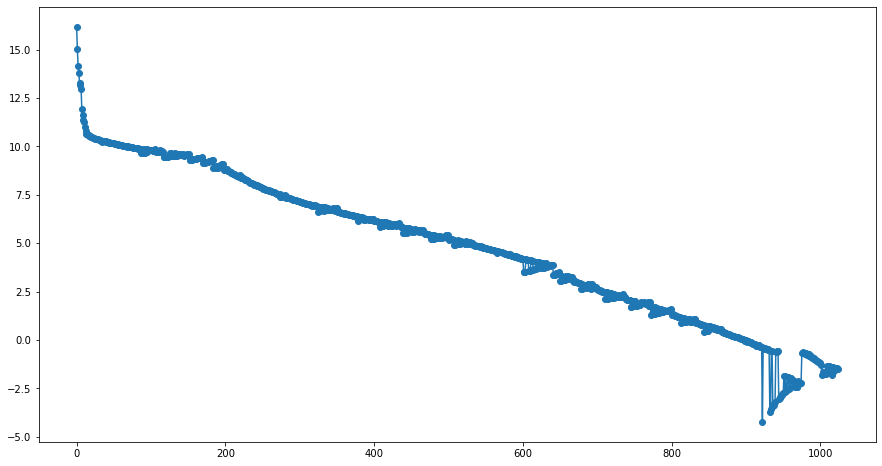

In [12]:
eigval, eigvec = np.linalg.eig(covmat)
plt.plot(np.log(eigval), 'o-')

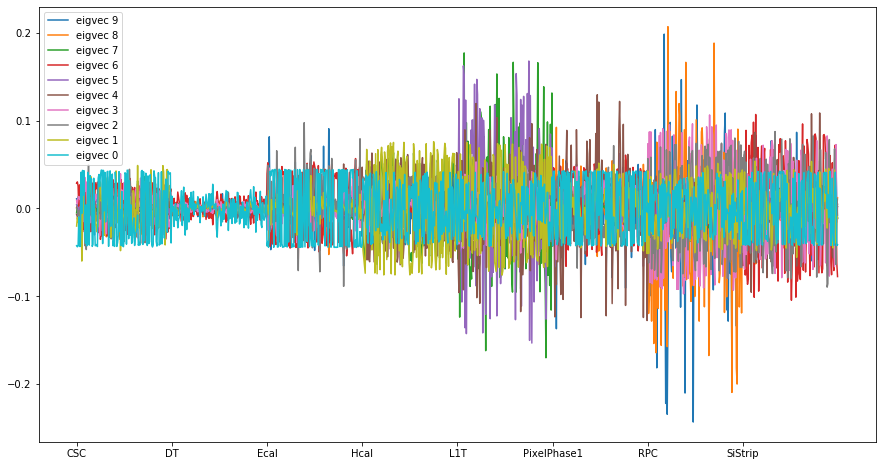

In [13]:
# 10 seems to work well for a wide range of setups...
NDIM = 10
ax = plt.subplot(111)
for i in reversed(range(NDIM)):
    ax.plot(eigvec[:,i], label = "eigvec %d" % i)
ticks = list(range(0,len(labels), ndimeach))
ax.set_xticks(ticks)
ax.set_xticklabels([labels[t] for t in ticks])
ax.legend()

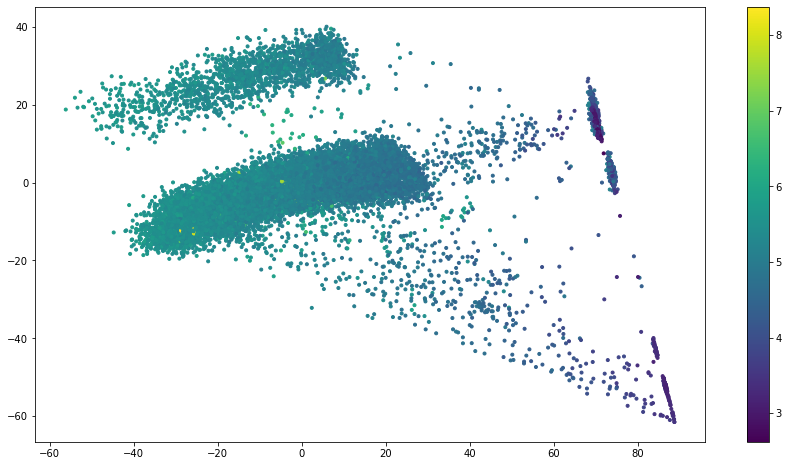

In [14]:
coeff = m.dot(eigvec[:,0:NDIM])
reco = coeff.dot(eigvec.transpose()[0:NDIM,:])
mse = ((m-reco)**2).sum(axis=1)

plt.scatter(coeff[:,0], coeff[:,1], c = np.log(mse), marker = ".")
plt.colorbar()

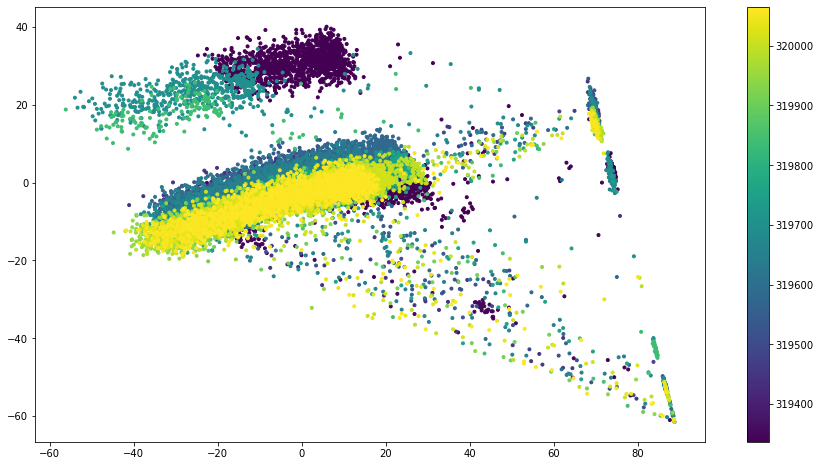

In [15]:
runlumi = np.array(runlumis, dtype=np.float32)
runs = runlumi[:,0]
lumis = runlumi[:,1]

# color by runs
plt.scatter(coeff[:,0], coeff[:,1], c = runs, marker = ".")
plt.colorbar()

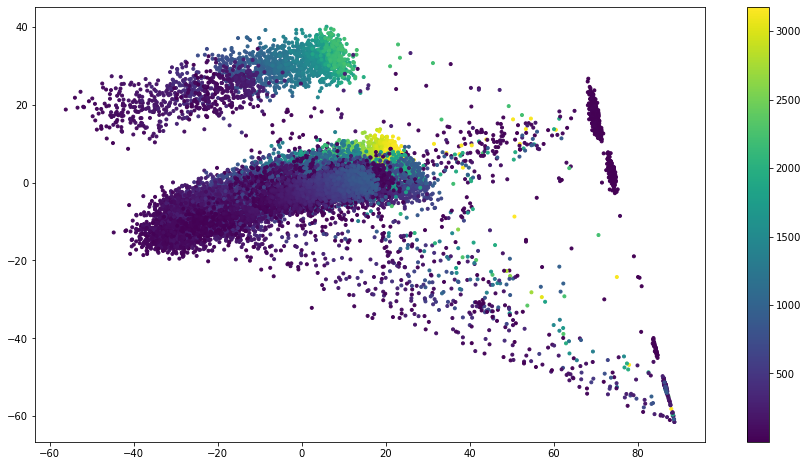

In [17]:
# color by lumis
plt.scatter(coeff[:,0], coeff[:,1], c = lumis, marker = ".")

plt.colorbar()

[(319337, 1613),
 (319486, 68),
 (319486, 69),
 (319503, 1),
 (319503, 2),
 (319503, 3),
 (319503, 4),
 (319503, 5),
 (319503, 6),
 (319503, 7),
 (319528, 107),
 (319528, 108),
 (319528, 109),
 (319528, 110),
 (319528, 111),
 (319528, 112),
 (319528, 113),
 (319528, 114),
 (319528, 115),
 (319528, 116),
 (319528, 117),
 (319528, 118),
 (319528, 119),
 (319528, 120),
 (319528, 121),
 (319528, 122),
 (319528, 123),
 (319756, 559),
 (320040, 145),
 (320040, 146),
 (320040, 147),
 (320040, 151),
 (320040, 153),
 (320040, 154),
 (320040, 155),
 (320040, 156),
 (320040, 157),
 (320040, 158),
 (320040, 159),
 (320040, 160),
 (320040, 161),
 (320040, 162),
 (320040, 163),
 (320040, 164),
 (320040, 165),
 (320060, 2),
 (320060, 3),
 (320060, 4),
 (320060, 5)]

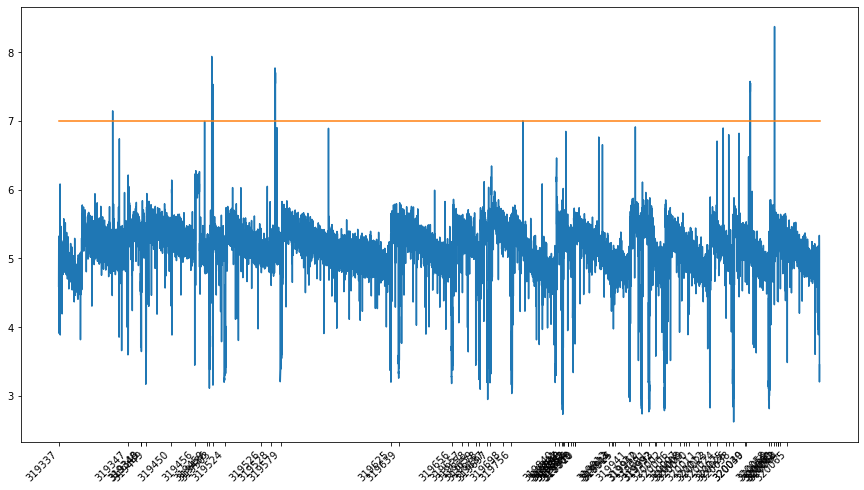

In [46]:
NOUTLIERS = 50 # select that many of the worst outliers

# put run numbers on the axis
seenruns = set()
def isfirst(run):
    if run not in seenruns:
        seenruns.add(run)
        return True
    else:
        return False
ticks = [idx for idx, run in enumerate(runs) if isfirst(run)]
ticklabels = ["%d" % runs[idx] for idx in ticks]

ax = plt.subplot(111)
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels, rotation=45, ha='right')
plt.plot(np.log(mse))
thres = sorted(list(np.log(mse)))[-NOUTLIERS]
plt.plot([0, len(mse)], [thres, thres])

# list the lumis above the threshold
abnormal = [i for i, err in enumerate(mse) if np.log(err) > thres]
[runlumis[i] for i in abnormal]

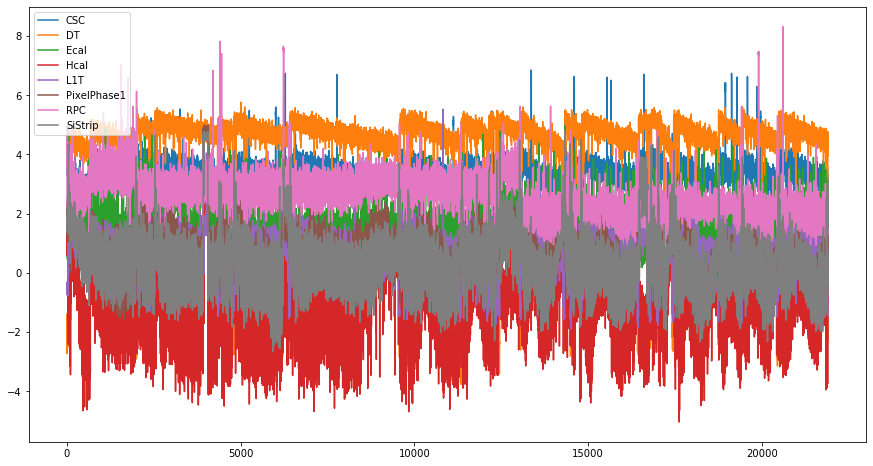

In [22]:
# create a breakdown of subsystems
msemat = ((m-reco)**2)
mses = dict()
for i in range(0, len(labels), ndimeach):
    # focus on a single run
    #submse = msemat[[idx for idx, (run, lumi) in enumerate(runlumis) if run == 319456],i:i+ndimeach].sum(axis=1)
    submse = msemat[:,i:i+ndimeach].sum(axis=1)
    mses[labels[i]] = submse
    plt.plot(np.log(submse), label=labels[i])
plt.legend()

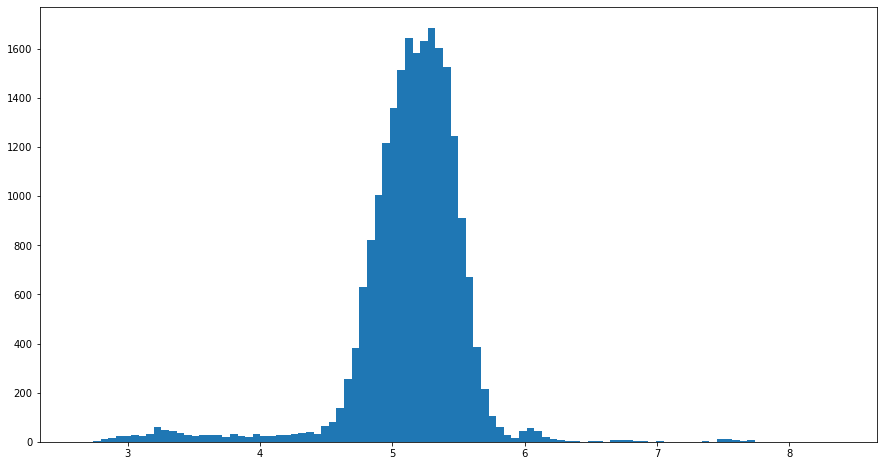

In [24]:
_ = plt.hist(np.log(mse), bins=100)

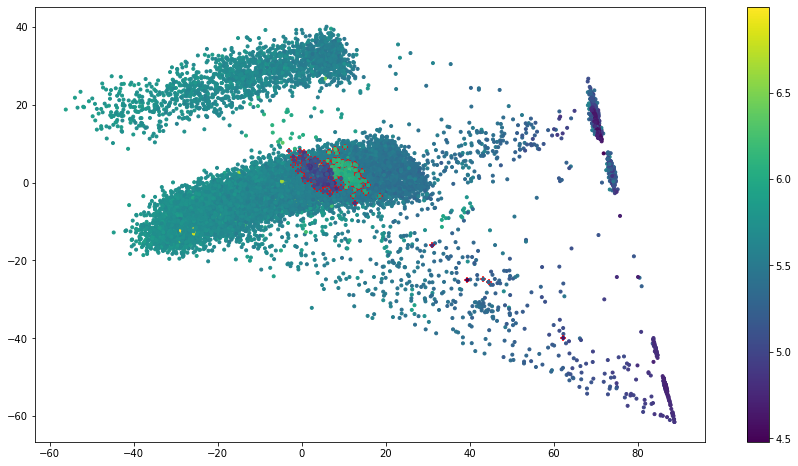

In [42]:
# more detailed analysis of one run
RUN=319456
onerun = [idx for idx, (run, lumi) in enumerate(runlumis) if run == RUN]
plt.scatter(coeff[:,0], coeff[:,1], c = np.log(mse), marker = ".")
plt.scatter(coeff[onerun,0], coeff[onerun,1], c = "red", marker = "+")
plt.scatter(coeff[onerun,0], coeff[onerun,1], c = np.log(mse[onerun]), marker = ".")
#plt.scatter(coeff[onerun,0], coeff[onerun,1], c = lumis[onerun], marker = ".")

plt.colorbar()